# Advance Lane Detection
#### Objective : 
In last project we were able to detect straight white and yellow lines on road images . 
But what if there is shadow on image or lines are curved then previous method will not work efficiently.
So, in this project we have to detect lane lines and position of vehical on images with shadows and curved lanes.

#### Steps to Achieve Obejective :
1. Camera caliberation
2. Line Detection
3. Perspective Transformation
4. Lane Line Formation
5. Curvature and Vehical Position Identification
6. Imposing the detected lines on real image
7. Implementation on Video Clip


In [1]:
## Libaries required for running the code in order to show the result of each function

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline
from sklearn.externals import joblib
from AdvanceLaneFinding import *

In [2]:
## Import all the chessboard images given for camera caliberation
files = glob.glob("camera_cal/*.jpg") #### chess board images

## 1. Camera Caliberation

##### Why we need this 
In real life images are not in perfect form means that due the curvature in camera lens the image becomes distorted or 
curved on edges. This imperfection will result in wrong line detection as image is strecthed out or curved at the corners 
and outer edges. To remove this effect we need to find the correct projection of distroted images. 

##### How to do it 
Now, if we take any random image it becomes difficult to get the projection transformation . So, we use chess board images to get the distrotion coeff or transformation coeff. As in image we can locate the projection of corners easilt by seeing the squares making it.Following steps are involved :
1. Get the inside square corners(corner at which 2 black and 2 white squares meet) on chessboard using function "cv2.findChessboardCorners
2. Using these corners calculate distrotion coefficients by "cv2.calibrateCamera" function. So, here function calculates the projection of distroted image corners on correct frame and will give us coeff which desribes how much relocation is needed and how to position the squares

##### How output looks 
1. Output of corner detecction
2. undistorted chessboard image


Text(0.5,1,'Corners Identified Image')

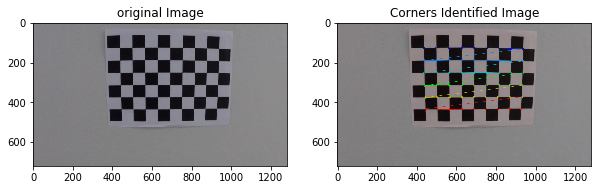

In [3]:
## Output 1  : Chessboard corner detection

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(mpimg.imread(files[16]))
plt.title("original Image")
plt.subplot(1,2,2)
plt.imshow(camera_caliberation(files[16],9,6)['img'])
plt.title("Corners Identified Image")

In [4]:
## Distortion Coeff Calculation
### save the distortion coeff file for use on real road images 

imgpoints,objpoints = obj_img_points(files,9,6)
img = mpimg.imread(files[0])
retval, cameraMatrix, distCoeffs, rvecs, tvecs=cv2.calibrateCamera(objpoints,imgpoints,img.shape[1::-1],None,None)
undist_dict = {'cameraMatrix':cameraMatrix,'distCoeff':distCoeffs}  ## save the caliberation coeff
joblib.dump(undist_dict,"undist_dict.pkl")

/home/workspace/CarND-Advanced-Lane-Lines/AdvanceLaneFinding.py:52: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if temp_dict['corner']!='NA':


['undist_dict.pkl']

Text(0.5,1,'Undistroted Image')

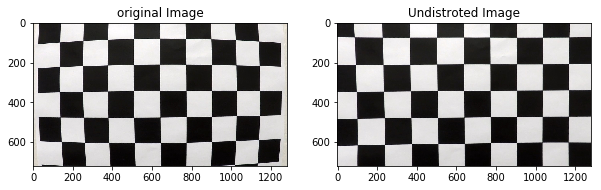

In [5]:
## Output 2 : undistroted image (original image is curved around edges)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(mpimg.imread(files[9]))
plt.title("original Image")
plt.subplot(1,2,2)
plt.imshow(cv2.undistort(mpimg.imread(files[9]),cameraMatrix,distCoeffs,None,cameraMatrix))
plt.title("Undistroted Image")

## 2. Line Detection 

##### How to do it
###### Steps to follow :
1. Undistrot the image using camera caliberation coeff from previous section
2. Sobel Gradient* to idetify edges on gray image
3. Change the color space* of the image to avoid the imapct of shadows on edge detection
4. Color Thresholding to identify edges
5. Combine color and sober gradient thresholds to get final edges

##### Definitions
###### *Sobel Gradient : 
It works in similar fashion as canny edge detector which calculates the gradient on gray image to identify
edges.It is different from canny's in how it is implemented that is :
1. Sobel is combination of gaussian smooting(noise removal in previous project) and sobel kernel. It is similar to applying convolution layer at each pixel to get the gradient 
2. Canny is gradient diff across the x and y direction based on local value . To get good results we need to apply gausssian
smoothing separatly 

###### *Color Space : To get human eye level visuals in colors for computer graphics color spaces other then RGB were made
such as HLS (Hue , Lighness, Saturation ) , HLV (Hue ,Lightness, Value). This spaces are able to provide different shades of 
same color like bright, dark,dull etc. effects.
1. Hue : Color , if base color is same then its value wont Change
2. Saturation : While mixing color how much the mixture is saturated with them
3. Lightness : 0 - black , 1 - white . How much light or brightness is in color
4. Value : It describes the brightness of the color

In [6]:
## Loading road images given for testing
test_images = glob.glob("test_images/*.*") 

Text(0.5,1,'Undistroted Image')

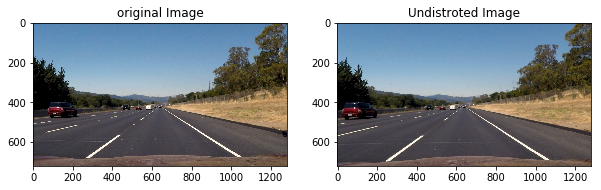

In [7]:
## output after removing distortion (using coeff from step 1)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(mpimg.imread(test_images[5]))
plt.title("original Image")
plt.subplot(1,2,2)
plt.imshow(cv2.undistort(mpimg.imread(test_images[5]),cameraMatrix,distCoeffs,None,cameraMatrix))
plt.title("Undistroted Image")

Text(0.5,1,'Edge Identification Image')

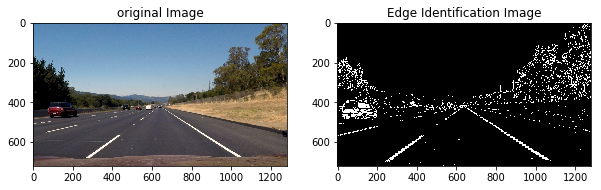

In [8]:
## output after edge detection using gradient and color threshold

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(mpimg.imread(test_images[5]))
plt.title("original Image")
plt.subplot(1,2,2)
edge_img =undist_color_gradient(mpimg.imread(test_images[5]),cameraMatrix,distCoeffs,sx_thresh = (20,100),s_thresh = (170,255))
plt.imshow(edge_img,cmap='gray')
plt.title("Edge Identification Image")

## 3. Perspective Transformation

##### Why we need this
In the image from front of car it is difficult to identify curvature of lane lines and they looks like converging on one point.So to get the correct curvature and distance between lanes for self driving car to move the steering is necessary. For this we need bird-eye view or top-down view.

##### How to do it 
Get the perspective transformation matrix by providing source points for lane lines (to form trapezoid) in original image and destination points (where we want it to be in new space)

###### Note : Perspective transformation is not easy(at least for me) so we start with straight line image . I have faced lot of difficulty in finding the correct destination points . Following things might be useful (from experience ):
1. Take image with straight line first
2. Take source points which forms a trapezoid not triangle as in real world lanes are parallel and in bird-eye view they should look parallel. So, if you take trianglular points then in perspective transformation also it will look converging as we are going to make transformation of same point 
3. While choosing source points, try to select which excludes the noisy edges in image
4. Now comes destination points : Start with origin as top left point and add the width and height of the trapezoid (take max out of 2 widths and heights) to get other four corner. Always remember we have to make a rectangle .
5. Keep increasing the origin by adding like (0+100) for 3-4 trials and observe how projection is moving.Then you can finalize by detecting the direction of movement how much it needs to be increased or decreased


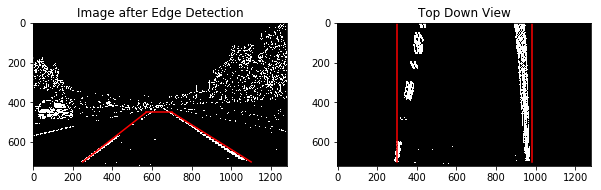

In [9]:
## Bird Eye View of image with trapezoid and rectangle marked respectively

M, warped,orig_pts,dest_o = perspective_change(edge_img)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(edge_img,cmap='gray')
plt.title("Image after Edge Detection")
for j in range(len(orig_pts)):
    if j <3:
        plt.plot([orig_pts[j][0],orig_pts[j+1][0]],[orig_pts[j][1],orig_pts[j+1][1]],color='r')

plt.subplot(1,2,2)
plt.imshow(warped,cmap='gray')
plt.title("Top Down View")
for j in range(len(dest_o)):
    if j in [0,2]:
        plt.plot([dest_o[j][0],dest_o[j+1][0]],[dest_o[j][1],dest_o[j+1][1]],color='r')
    

## 4. Lane Line Formation

##### Why we need this 
In previous we are able to identify the edges not the exace lane lines. 

##### How to do it 
Lane lines can be straight or curved. There two type of polynomial function possible for lane lines linear or quadratic. But in real life scenario if take quadratic (2nd order polynomial) then both the cases will be covered.We will create sliding window and keep on moving it such a way so that edge pixel fall in that window. If not then we have to adjust the vertices of window.Following steps for creating sliding windows :
1. Create histogram of bottom half of image by summing up the pixel values on gray image(1 for edge else 0).In histogram there will be 2 peeks one on right and other on left , which signifies the left and right x coordinates for start
2. Now we need to define how many windows we want to create and of what height and width . So that we can move the window up for identifying the lane path.
3. More the number of windows, more accurate will be the curve but it will take time to run.So, choose optimaly.
4. Now we need to define the stopping criteria for window validity. That is edge pixels should fall within window that will be min pix value. If it is not falling then we can change the x coordinates by  mean of the pixels in wrong window which are coinciding with edge pixels
5. Above 4 steps will give the right and left x-y coordinates. with them we can fit 2nd order polynomial to get the lane line using numpy's polyfit function.

Then draw the sliding window and curved lane line on bird-eye perspective

In [10]:
out_img,ploty,left_fit,right_fit,left_fitx,right_fitx = fit_polynomial(warped,nwindows = 9,margin = 100,minpix = 50,ym_per_pix=1,xm_per_pix=1)

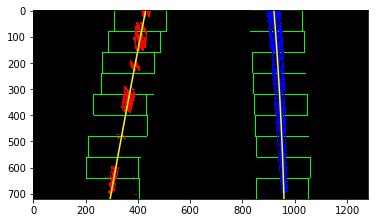

In [11]:
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')


## 3. Curvature and Vehical Position Identification 
Here we calculate the radius of the curve fitted in previous step for identifying lane lines and position of vehical assuming that camera is fitted on car's roof in middle.So center of the lanes can be taken as position

Output :
1. Calculation using pixel values 
2. Calculation w.r.t real world conversion of pixel


In [12]:
## output 1
left_curverad,right_curverad,center = curvature_vehical_pos(ploty,left_fit,right_fit,y=700,ym_per_pix=1)

For conversion from pixel to real world

In [13]:
ym_per_pix = 30/720  
xm_per_pix = 3.7/1280 

In [14]:
## output 2
out_img_o,ploty_o,left_fit_o,right_fit_o,left_fitx_o,right_fitx_o = fit_polynomial(warped, 9,100,50,ym_per_pix,xm_per_pix)
left_curverad_o,right_curverad_o,center_o= curvature_vehical_pos(ploty_o,left_fit_o,right_fit_o,700,ym_per_pix)

## 4. Imposing Detected Lines on Undistorted Image

##### Following steps :

1. Here we are going to use the inverse of perpective transformation that we have used in 3rd step to wrap the detected lane lines over original image after removing distortion .
2. Use "cv2.polyfill" function to fill the area detected between lanes
3. Put the left curvature , right curvature and position of vehical on the same image

Text(0.5,1,'After Lane Detection Image')

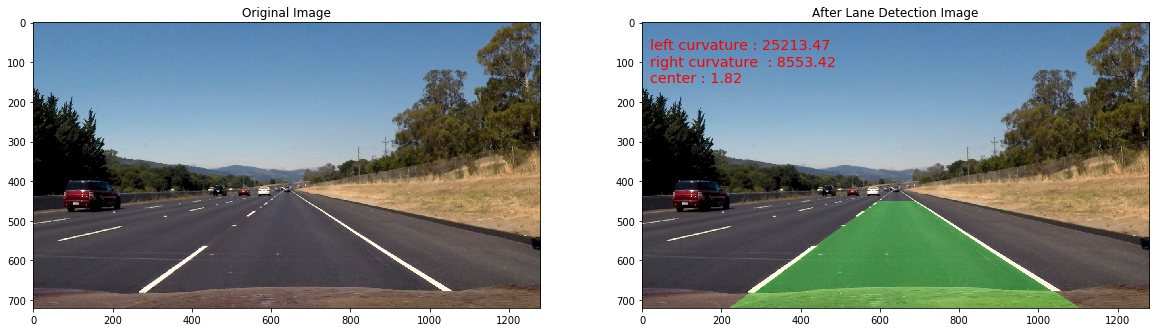

In [15]:
image = mpimg.imread(test_images[5])
out_img_o,ploty_o,left_fit_o,right_fit_o,left_fitx_o,right_fitx_o = fit_polynomial(warped, 9,100,50,ym_per_pix,xm_per_pix)
left_curverad_o,right_curverad_o,center_o= curvature_vehical_pos(ploty_o,left_fit_o,right_fit_o,700,ym_per_pix)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(impose_lines_orig_image(dest_o,orig_pts,warped,left_fitx,right_fitx,ploty,image,left_curverad,right_curverad,center))
plt.text(20,150,"left curvature : {} \nright curvature  : {} \ncenter : {}  ".format(round(left_curverad_o,2),round(right_curverad_o,2),round(center_o,2))
        ,color='r',fontsize='x-large')
plt.title("After Lane Detection Image")